- In this notebook, we demonstrate how to calculate the Variance Inflation Factor (VIF) (Ref[1]), which is a useful metric to measure if multicollinearity (Ref[2]) exists in a regression problem. 

- We use the blood pressure data set provided in Ref[3] as an example. The data set has 1 target (BP) and 6 predictors (Age, Weight, BSA, Dur, Pulse, Streee). Some discussion about the data set can be found in Ref[4]



- For a Ordinal Least Square Linear Regression, one can show that the estimated coefficient $\hat\beta$ and the variance $Var(\hat\beta)$ can be written as (cf. Ref[5])

$
\hat\beta = (X^T X)^{-1} X^T \vec{y}  \hspace{500pt}
$

$
Var(\hat\beta) = \sigma^2 (X^T X)^{-1} \hspace{500pt}
$

Where $\sigma$ refers to the standard deviation of the target $\vec{y}$.

- One can show that the variances of the individual components are:

$
\dfrac{Var(\hat\beta_j)}{\sigma^2} = \vec{x_j}^T \vec{x_j} \big[ \vec{x_j}^T \vec{x_j} - (\vec{x_j}^T X_{-j}) (X_{-j}^T X_{-j})^{-1} (X_{-j}^T \vec{x_j})  \big]^{-1} \hspace{500pt}
$

where $\vec{x_j}$ is the jth column of the design matrix X, and $X_{-j}$ stands for $X$ with the jth column removed.

Notice that we do not assume each column of X be unit-vector scaled, that's why we have a $\vec{x_j}^T \vec{x_j}$ in the beginning of the expression to conform with the standard expression (Ref[6]).

- The above expression is actually the definition of VIF for jth component, and assuming that **the feature vectors are centered**, one can show that: (Ref[7])

$
VIF_j \equiv \dfrac{Var(\hat\beta_j)}{\sigma^2} = \dfrac{1}{1 - R^2_{-j}}  \hspace{500pt}
$

where $R^2_{-j}$ is the R-squared based on doing regression of $\vec{x_j}$ on the rest of the predictors $X_{-j}$.



- References:

[1] https://en.wikipedia.org/wiki/Variance_inflation_factor

[2] https://en.wikipedia.org/wiki/Multicollinearity

[3] http://sites.stat.psu.edu/~lsimon/stat501wc/sp05/data/

[4] https://onlinecourses.science.psu.edu/stat501/node/347

[5] Chapter 3 of Elements of Statistical Learning, ,Trevor Hastie, Jerome H. Friedman, Robert Tibshirani

[6] http://stats.stackexchange.com/questions/243315/variance-of-hat-mathbf-beta-j-in-multiple-linear-regression-models

[7] http://stats.stackexchange.com/questions/244468/equation-for-the-variance-inflation-factors



In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
data = pd.read_csv('bloodpress.txt', sep='\t', header=0)
data = data.drop(['Pt'], axis=1)

In [4]:
data.columns

Index(['BP', 'Age', 'Weight', 'BSA', 'Dur', 'Pulse', 'Stress'], dtype='object')

In [5]:
response = 'BP'
features = ['Age', 'Weight', 'BSA', 'Dur', 'Pulse', 'Stress']

In [6]:
data[features].corr()

,Age,Weight,BSA,Dur,Pulse,Stress
Age,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Weight,0.407349,1.000000,0.875305,0.200650,0.659340,0.034355
BSA,0.378455,0.875305,1.000000,0.130540,0.464819,0.018446
Dur,0.343792,0.200650,0.130540,1.000000,0.401514,0.311640
Pulse,0.618764,0.659340,0.464819,0.401514,1.000000,0.506310
Stress,0.368224,0.034355,0.018446,0.311640,0.506310,1.000000


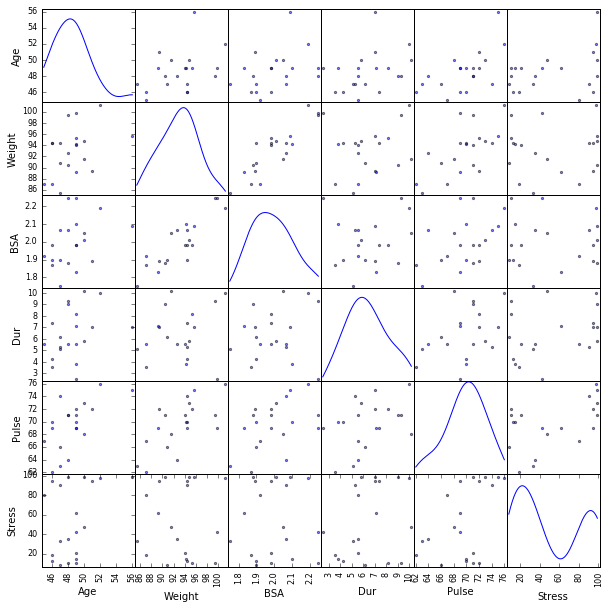

In [7]:
sc_mtx = pd.tools.plotting.scatter_matrix(data[features], figsize=(10, 10), diagonal='kde')

From the above pair-wise correlation matrix and plots, we can see that Weight and BSA are highly correlated.

In the following, we will demonstrate how to calculate VIF for each of the predictors, using the two formula shown above, and show that they are equivalent. In addition, the statsmodel package also provides a function to calculate VIF, we will use it as a verification. 

In [9]:
# First formula, based on the variance of component j
def calculateFormulaVar(xj, Xj):
    n = xj.dot(xj)
    m1 = xj.T.dot(Xj)
    m2 = np.linalg.inv(Xj.T.dot(Xj))
    m3 = Xj.T.dot(xj)
    return n/(n - m1.dot(m2).dot(m3))

# Second formula, which requires the design matrix be centered
def calculateFormulaR2(xj, Xj):
    lg = LinearRegression(fit_intercept=True, normalize=False)
    lg.fit(Xj, xj)
    R2_j = r2_score(xj, lg.predict(Xj))
    return 1.0/(1-R2_j)
    

# We first center and rescale the design matrix
X = data[features].values
mu = np.mean(X, axis=0)
std = np.std(X, axis=0)
stdX = (X - mu)/std
    
    
# start calculation for each feature    
formula_var = []
formula_R2 = []
states_model_res = []

for j in range(stdX.shape[1]):
    target_idx = j
    feature_idx = [i for i in range(stdX.shape[1]) if i != target_idx]
    
    xj = stdX[:, target_idx]
    Xj = stdX[:, feature_idx]
    
    formula_var.append(calculateFormulaVar(xj, Xj))
    formula_R2.append(calculateFormulaR2(xj, Xj))
    states_model_res.append(variance_inflation_factor(stdX, j))
    
    
df = pd.DataFrame({'feature': features, 
                   'VIF from var': formula_var,
                   'VIF from R2': formula_R2, 
                   'statsmodel': states_model_res})
df = df[['feature', 'VIF from var', 'VIF from R2', 'statsmodel']]
df

,feature,VIF from var,VIF from R2,statsmodel
0,Age,1.762807,1.762807,1.762807
1,Weight,8.417035,8.417035,8.417035
2,BSA,5.328751,5.328751,5.328751
3,Dur,1.237309,1.237309,1.237309
4,Pulse,4.413575,4.413575,4.413575
5,Stress,1.834845,1.834845,1.834845



Note that having multicollinearity in the predictors does **not** necessarily affect the predictive power in the regression model. The following code does linear regression and calculates the R2 with 1) the full list of features, 2) the list of features with Weight (highest VIF feature) removed.


In [23]:
lg = LinearRegression(fit_intercept=True, normalize=False)
lg.fit(stdX, data[response])
R2_full = r2_score(data[response], lg.predict(stdX))
print('with the full list of features, R2={0:.3f}'.format(R2_full))
print('features: {0:}'.format(features))
print('coefficients: {0:}'.format(lg.coef_))
print('')

lg = LinearRegression(fit_intercept=True, normalize=False)
feature_idx = [0, 2, 3, 4, 5]
lg.fit(stdX[:,feature_idx], data[response])
R2_partial1 = r2_score(data[response], lg.predict(stdX[:, feature_idx]))
print('with Weight ignored, R2={0:.3f}'.format(R2_partial1))
print('features: {0:}'.format(np.array(features)[feature_idx]))
print('coefficients: {0:}'.format(lg.coef_))
print('')


with the full list of features, R2=0.996
features: ['Age', 'Weight', 'BSA', 'Dur', 'Pulse', 'Stress']
coefficients: [ 1.7139919   4.06023526  0.50237267  0.14298598 -0.31316366  0.2013947 ]

with Weight ignored, R2=0.926
features: ['Age' 'BSA' 'Dur' 'Pulse' 'Stress']
coefficients: [ 1.37206986  3.26629837  0.16062286  1.6918976  -0.60487654]



As explained in Ref. [2], the issues caused by multicollinearity are that:

1) $X^T X$ maybe non-invertible, because the rank of $X$ gets reduced due to multicollinearity

2) The interpretation of the coefficients may be incorrect when multicollinearity is present. For example, in the above two regresion models, the first model seems to suggest that one unit increase in BSA will increase the blood pressure by only 0.5, while the second model (less multicollinearity) says that one unit increase in BSA is actully causing 3.3 increase in the blood pressure.